In [9]:
import os
from PIL import Image

def convert_images_to_greyscale(source_folder, destination_folder):
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Loop through all files in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith(".tif"):
            # Open the image file
            img_path = os.path.join(source_folder, filename)
            with Image.open(img_path) as img:
                # Convert to greyscale
                grey_img = img.convert("L")
                
                # Save to the destination folder with the same filename
                grey_img.save(os.path.join(destination_folder, filename))

# Example usage
source_folder = 'DRIVE/test/images'
destination_folder = 'DRIVE/test/grey'

convert_images_to_greyscale(source_folder, destination_folder)

number of images: 20
number of annotations: 20
torch.Size([1, 256, 256]) torch.FloatTensor tensor(1.)
torch.Size([1, 256, 256]) torch.FloatTensor tensor(1.)
16
----------
4
16
4
torch.Size([4, 1, 256, 256]) torch.float32
torch.Size([4, 1, 256, 256]) torch.float32
torch.Size([4, 1, 256, 256]) torch.float32
torch.Size([4, 1, 256, 256]) torch.float32
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)

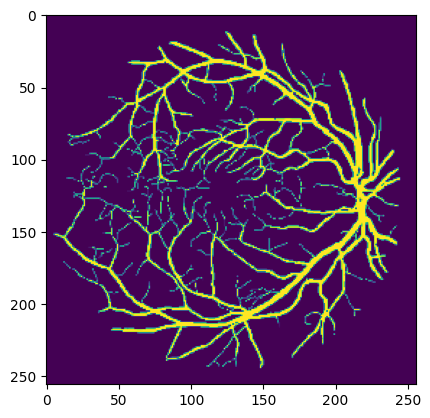

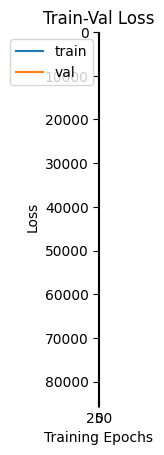

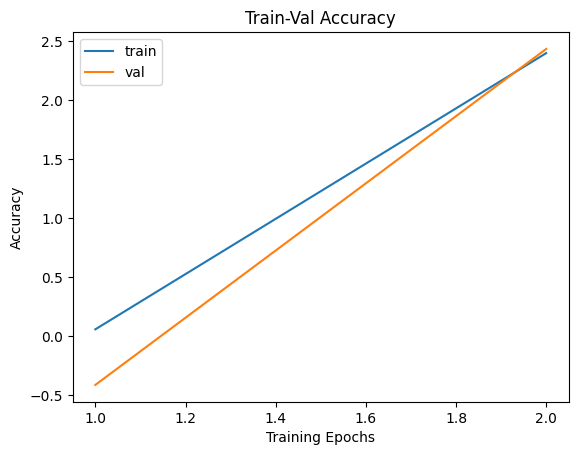

torch.Size([1, 256, 256]) torch.FloatTensor tensor(0.8902)
torch.Size([1, 256, 256]) torch.FloatTensor tensor(1.)
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
(1, 1, 256, 256)
(256, 256)
[[0.4672224  0.46698117 0.46659437 ... 0.4668021  0.47031763 0.47154945]
 [0.46407816 0.46308    0.4614118  ... 0.46262547 0.46715683 0.46822685]
 [0.46279392 0.46132326 0.45931116 ... 0.4611362  0.46682832 0.46797422]
 ...
 [0.46317413 0.46124256 0.45776212 ... 0.45989707 0.46624464 0.46767327]
 [0.46600416 0.46613157 0.46313235 ... 0.46434563 0.4701305  0.46978727]
 [0.46846837 0.46696153 0.46586758 ... 0.46578303 0.467001   0.4685185 ]]


<Figure size 640x480 with 0 Axes>

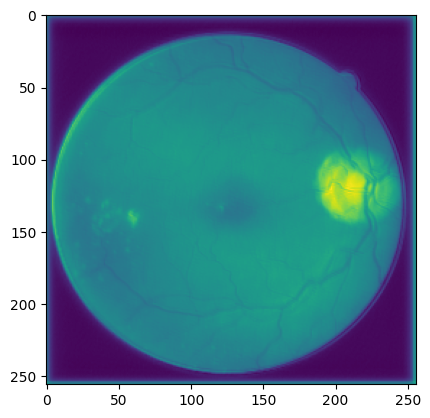

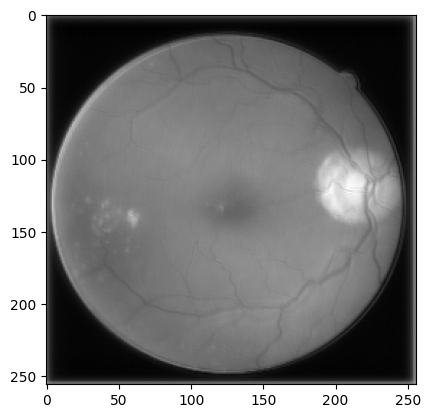

In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms.functional import to_tensor
from torchvision import transforms, datasets, models
from albumentations import HorizontalFlip, VerticalFlip, Compose, Resize
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
from torch import optim

# Data directory paths
data_dir = "DRIVE/training/1st_manual"
mask_dir2 = "DRIVE/training/mask"

# Listing images and masks
imgsList = [pp for pp in os.listdir(data_dir)]
anntsList2 = [pp for pp in os.listdir(mask_dir2)]

print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList2))

from albumentations import (HorizontalFlip,VerticalFlip,Compose,Resize)
h,w=256,256

#transform_train = Compose([ Resize(h,w),HorizontalFlip(p=0.5),VerticalFlip(p=0.5),])
transform_train = Compose([ Resize(h,w)])
transform_val = Resize(h,w)
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor
#from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, datasets, models

class fetal_dataset(Dataset):
       def __init__(self, path2data,path2label2,num_class, transform=None):
          imgsList=[pp for pp in os.listdir(path2data)]
          anntsList2=[pp for pp in os.listdir(path2label2)]
          self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
          self.path2annts2= [os.path.join(path2label2, fn) for fn in anntsList2]
          self.transform = transform
          self.num_class =num_class
       def __len__(self):
          return len(self.path2imgs)
 
       def __getitem__(self, idx):
          path2img = self.path2imgs[idx]
          image = Image.open(path2img)
          path2annt2 = self.path2annts2[idx]
          mask2 = Image.open(path2annt2)
          image= np.array(image)
          mask2=np.asarray(mask2)
          if self.transform: 
             augmented = self.transform(image=image, mask=mask2 )
             image = augmented['image']
             mask2 = augmented['mask']
#             mask2=mask2.transpose(2,1,0)
             mask2=mask2.astype(np.float32)
          image= to_tensor(image)   
          mask2=to_tensor(mask2)
          mask2=mask2/torch.max(mask2)
          
          return image, mask2
  

fetal_ds1=fetal_dataset(data_dir,mask_dir2,1, transform=transform_train)
fetal_ds2=fetal_dataset(data_dir,mask_dir2,1, transform=transform_val)

img,msk1=fetal_ds1[0]
#show_img_mask(img, mask)
print(img.shape, img.type(),torch.max(img))
print(msk1.shape, msk1.type(),torch.max(msk1))
plt.figure(),plt.imshow(img[0])
plt.figure(),plt.imshow(msk1[0])

from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=range(len(fetal_ds1))
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))


from torch.utils.data import Subset
train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))
val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break
#image_datasets = {'train': train_set, 'val': val_set}
batch_size = 1
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)
}

import torchvision.utils
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)


class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  # nn.Conv2d(ch_out, ch_out,
                                  #           kernel_size=3, stride=1,
                                  #           padding=1, bias=True),
                                  # nn.BatchNorm2d(ch_out),
                                  # nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=1, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        #
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

# model = AttentionUNet()
# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(n_classes=1).to(device)
model=model.to(device)
print(model)
output = torch.randn(1,1,256,256).to(device)
output.shape
torch.Size([1, 1, 256, 256])

from torchsummary import summary
summary(model, input_size=(1, 256, 256),device=device.type)


def dice_loss(pred, target, smooth = 1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice
    return loss.sum(), dice.sum()

import torch.nn.functional as F
def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,reduction='sum')
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    return loss
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    return metric

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    _, metric_b=dice_loss(output, target)
    if opt is not None:
       opt.zero_grad()
       loss.backward()
       opt.step()
    return loss.item(), metric_b
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr=get_lr(opt)
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float32).to(device)
        yb=yb.type(torch.float32).to(device)
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if metric_b is not None:
           running_metric+=metric_b
        if sanity_check is True:
           break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric
import time
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs- 1, current_lr))
        since = time.time()
        model.train() 
        train_loss,train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric.item())
        model.eval()
        with torch.no_grad():
             val_loss,val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric.item())
        if val_loss < best_loss:
           best_loss = val_loss
           best_model_wts = copy.deepcopy(model.state_dict())
           torch.save(model.state_dict(), path2weights)
           print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        #if current_lr == get_lr(opt):
        print("Loading best model weights!")
        model.load_state_dict(best_model_wts)
        print("train loss: %.6f, dice: %.2f"%(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f"%(val_loss,100*val_metric))
        print("-"*10)
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

#path2models= "/media/mithun/BA423E4C423E0E1F/1PHD_NITP/2020/Glucoma_Research_Python/New_research/"
path2models= "Attention/"
if not os.path.exists(path2models):
   os.mkdir(path2models)
params_train={
"num_epochs":2,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": path2models+"weights_vessel_attn.pt",
}
model,loss_hist,metric_hist=train_val(model,params_train)
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()    

test_dataset = "DRIVE/test/grey"

mask_dir_test_2="DRIVE/test/mask"

test_fetal_ds1=fetal_dataset(test_dataset,mask_dir_test_2,1, transform=transform_val)
test_img,test_msk1=test_fetal_ds1[0]

#show_img_mask(img, mask)
print(test_img.shape, test_img.type(),torch.max(test_img))
print(test_msk1.shape, test_msk1.type(),torch.max(test_msk1))

test_loader = DataLoader(test_fetal_ds1, batch_size=1, shuffle=True)
#inputs, masks = next(iter(test_loader))

#print(inputs.shape, masks.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((2, 1, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

inputs, labels = next(iter(test_loader))
plt.figure()
#plt.imshow(reverse_transform(inputs))
inputs = inputs.to(device)
labels = labels.to(device)
print(inputs.shape, labels.shape)
#
#
## Predict
pred = model(inputs)
## The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)
pred=np.squeeze(pred)
print(pred.shape)
print(pred)
plt.figure()
plt.imshow(pred)
plt.figure()
plt.imshow(pred,cmap='gray')